# Fantasy Premier League

In [1]:
import numpy as np
import pandas as pd
import requests
import xlsxwriter
import math
import matplotlib.pyplot as plt


### Basic Classes
Class structure to hold api data
 - Player: Class which holds mini-league player data
 - Mini_League: Class which holds data for the mini league
 - Gameweek: Each gameweek information

In [2]:
class Player:
    def __init__(self, name, rank, points, last_rank, manager_id):
        self.name = name
        self.rank = int(rank)
        self.points = int(points)
        self.last_rank = int(last_rank)
        self.manager_id = manager_id

    def get_rank(self):
        return self.rank

    def get_name(self):
        return self.name

    def get_points(self):
        return self.points
    
    def get_manager_id(self):
        return self.manager_id

    def __str__(self):
        pos = ''
        if self.rank == self.last_rank:
            pos = 'No Movement'
        elif self.rank > self.last_rank:
            move = self.rank - self.last_rank
            pos = f'Fell down by {move} positions'
        else:
            move = self.last_rank - self.rank
            pos = f'Moved up by {move} positions'
        return f'{self.name} with points {self.points} and current rank {self.rank}. {pos}'

class Score:
    def __init__(self, gameweek, points, rank, transfer_cost):
        self.gameweek = gameweek
        self.points = points
        self.rank = rank
        self.transfer_cost = transfer_cost
        
    def get_points(self):
        return self.points
    
    def get_gameweek(self):
        return self.gameweek
    
    def get_rank(self):
        return self.rank
    
    def get_transfer_cost(self):
        return self.transfer_cost
        
    
class Mini_League:
    def __init__(self, name, players):
        self.name = name
        self.players = players

    def getPlayers(self):
        return self.players

    def __str__(self):
        output = self.name + '\n'
        output = output + '-----------------------------------------------------------------------------------' + '\n'
        for player in self.players:
            output = output + player.__str__() + '\n'
        output = output + '-----------------------------------------------------------------------------------'
        return output
    
class Gameweek:
    def __init__(self, name, avg_score):
        self.name = name
        self.avg_score = avg_score

    def getName(self):
        return self.name

    def getAverageScore(self):
        return self.avg_score

### API calls

Fantasy football offers lot of interesting api's to load mini-league information, player details. More information can be found [at](https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19)

In [3]:

#Get gameweek data
def get_static_event_data():
    static_url = f'https://fantasy.premierleague.com/api/bootstrap-static/'
    static_data = requests.get(static_url).json()
    events = static_data['events']
    gameweek_data = []
    for event in events:
        if event['finished'] == True:
            gameweek_data.append(Gameweek(event['name'], int(event['average_entry_score'])))
    return gameweek_data

#Calculate total of average score for all the gameweeks
def get_average_score(gameweek_data):
    total_average = 0
    for i in gameweek_data:
        total_average = total_average + i.getAverageScore()
    return total_average

#Get mini league data
def get_classic_league_standings(league_code):
    league_standing_api_url = f'https://fantasy.premierleague.com/api/leagues-classic/{league_code}/standings'
    league_data = requests.get(league_standing_api_url).json()
    league_name = league_data['league']['name']
    league_standings = league_data['standings']['results']

    players = []
    for standing in league_standings:
        player_data = Player(standing['entry_name'], standing['rank'], standing['total'], standing['last_rank'], standing['entry'])
        players.append(player_data)
    return Mini_League(league_name, players)

league_code = input('Enter the league code: ')
league_data = get_classic_league_standings(league_code)

Enter the league code: 59187


### League standings
Horizontal bar chart showing mini-league standings

In [4]:
gw_data = get_static_event_data()

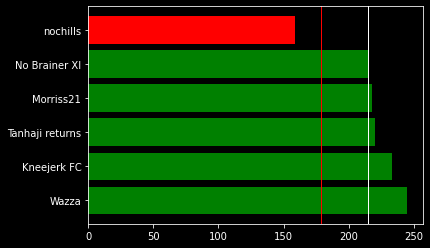

In [6]:
def get_horizontal_bar_chart(league):
    players = league.getPlayers()
    names = []
    points = []
    colors = []
    total_points = 0
    average_score = get_average_score(gw_data)
    for player in players:
        point = player.get_points()
        total_points = total_points + point
        names.append(player.get_name())
        points.append(point)
        if point > average_score:
            colors.append('green')
        elif point < average_score:
            colors.append('red')
        else:
            colors.append('blue')
    avg_league_points = total_points/len(points)
    y_pos = np.arange(len(points))
    fig, ax = plt.subplots()
    plt.style.use('dark_background')
    ax.axvline(average_score, color='red', linewidth=1)
    ax.axvline(avg_league_points, color='white', linewidth=1)
    #ax.set_title("'dark_background' style sheet")
    plt.barh(y_pos, points, color = colors)
    plt.yticks(y_pos, names)
    plt.show()

get_horizontal_bar_chart(league_data)

In [8]:
def get_manager_scores(manager_id):
    request_url = f'https://fantasy.premierleague.com/api/entry/{manager_id}/history/'
    response = requests.get(request_url).json()
    val = response['current']
    scores = []
    for data in val:
        score = Score(data['event'], data['points'], data['rank'], data['event_transfers_cost'])
        scores.append(score)
    return scores
#get_manager_scores('1591479')

#### Mini league player scores
Below code iterates over all the player scores for different gameweeks and calculates the final score (points - transfer cost).
Output is a dataframe containing player name and final points for the gameweek

In [9]:
players = league_data.getPlayers()
result = []
player_names = []

for p in players:
    player_names.append(p.get_name())
    p_id = p.get_manager_id()
    scores = get_manager_scores(p_id)
    gw_scores = []
    events1 = []
    for s in scores:
        events1.append(s.get_gameweek())
        gw_scores.append(s.get_points() - s.get_transfer_cost())
    temp = pd.Series(gw_scores, index = events1)
    temp.name = p.get_name()
    result.append(temp)
final_score = pd.DataFrame(result, columns = events1, index = player_names)
final_score

,1,2,3
Wazza,100,83,62
Kneejerk FC,88,86,59
Tanhaji returns,78,81,61
Morriss21,87,68,63
No Brainer XI,96,60,59
nochills,60,47,52


#### Mini league player ranks
Player ranks are calculated based on the points scored for each gameweek.
In case of tie between players same rank is shared

In [10]:
ranking_array = []
for column in final_score:
    rank_series = pd.to_numeric(final_score[column].rank(method = 'min', ascending = False), downcast='integer')
    ranking_array.append(rank_series)

final_rank =  pd.DataFrame(ranking_array).T
final_rank

,1,2,3
Wazza,1,2,2
Kneejerk FC,3,1,4
Tanhaji returns,5,3,3
Morriss21,4,4,1
No Brainer XI,2,5,4
nochills,6,6,6


In [52]:
gw_entry_cost = input("Enter each gameweek contribution amount per person: ")
gw_entry_cost = int(gw_entry_cost)
ledger = {}

def update_for_gw_losers(ledger, gw_entry_cost, gw_winner):
    for i,j in ledger.items():
            if i not in gw_winner:
                ledger.update({i: j - gw_entry_cost})
                
for name in player_names:
    ledger[name] = 0

for i in events1:
    a = final_rank[final_rank[i] == 1]
    if len(a.index) == 1:
        gw_winner = a.index[0]
        update_for_gw_losers(ledger, gw_entry_cost, {gw_winner})
        initial_amount = ledger.get(gw_winner)
        ledger.update({gw_winner: initial_amount + ((len(player_names) - 1) * gw_entry_cost)})
    else:
        winners = set()
        for p in range(0,len(a.index)):
            winners.add(a.index[p])
        update_for_gw_losers(ledger, gw_entry_cost, winners)
        amount = ((len(player_names) - len(winners)) * gw_entry_cost) / 2
        amount = round(amount, 2)
        #print(ledger)
        for w in winners:
            initial_amount = ledger.get(w)
            ledger.update({w: initial_amount + amount}) 

final_amount = pd.DataFrame(ledger.items())
final_amount

Enter each gameweek contribution amount per person: 100


,0,1
0,Wazza,300
1,Kneejerk FC,300
2,Tanhaji returns,-300
3,Morriss21,300
4,No Brainer XI,-300
5,nochills,-300
